In [ ]:
!pip install opencv-python matplotlib scikit-learn pillow

In [ ]:
#Check if there is a GPU Available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

# IMPORT DEPENDENCIES

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from PIL import Image  # Import Image module from Pillow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

#Different Pre-Trained Model
from efficientnet.tfkeras import EfficientNetB0  # Import EfficientNetB0
from keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam

C:\Users\janwi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# # Specify the path to your dataset
# train_dir = 'path_to_your_training_data_directory'
# validation_dir = 'path_to_your_validation_data_directory'

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# LOAD DATA (SPLIT DATA)

In [5]:
#shutil.rmtree('DATASET')
#print(f"Folder '{'DATASET'}' deleted successfully.")

In [5]:
original_dataset_path = 'CollectionOfDataVersion/dataOwn6ClassNew'

# Specify the path for the new train, validation, and test directories
base_dir = 'DATASET'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# List all subdirectories (categories) in the original dataset
categories = [category for category in os.listdir(original_dataset_path) if not category.startswith('.')]  # Exclude hidden directories

In [ ]:
# Specify the ratios for splitting (e.g., 45% training, 45% validation, 10% test)
train_ratio = 0.60
validation_ratio = 0.30
test_ratio = 0.10

# Iterate through each category and split the images
for category in categories:
    category_path = os.path.join(original_dataset_path, category)
    images = [image for image in os.listdir(category_path) if not image.startswith('.')]  # Exclude hidden files

    # Split the images into training, validation, and test sets
    train_images, test_images = train_test_split(images, test_size=test_ratio, random_state=42)
    remaining_images = list(set(images) - set(test_images))
    train_images, validation_images = train_test_split(remaining_images, test_size=validation_ratio / (train_ratio + validation_ratio), random_state=42)

    # Create subdirectories in the new train, validation, and test directories
    train_category_dir = os.path.join(train_dir, category)
    os.makedirs(train_category_dir, exist_ok=True)

    validation_category_dir = os.path.join(validation_dir, category)
    os.makedirs(validation_category_dir, exist_ok=True)

    test_category_dir = os.path.join(test_dir, category)
    os.makedirs(test_category_dir, exist_ok=True)
    
    # Create an ImageDataGenerator for augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

    validation_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

    # Loop over each training image and generate augmented versions
    for image_name in train_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(train_category_dir, image_name)

        # Load the original image
        img = image.load_img(source_path, target_size=(256, 256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # Generate augmented versions
        i = 0
        for batch in train_datagen.flow(x, batch_size=1, save_to_dir=train_category_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= 10:  # Generate 20 augmented versions per original image
                break

    # Loop over each validation image and generate augmented versions
    for image_name in validation_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(validation_category_dir, image_name)
        shutil.copyfile(source_path, destination_path)

#         # Load the original image
#         img = image.load_img(source_path, target_size=(256, 256))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)

#         # Generate augmented versions
#         i = 0
#         for batch in validation_datagen.flow(x, batch_size=1, save_to_dir=validation_category_dir, save_prefix='aug', save_format='jpeg'):
#             i += 1
#             if i >= 3:  # Generate 20 augmented versions per original image
#                 break

    # Copy test images without augmentation
    for image_name in test_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(test_category_dir, image_name)
        shutil.copyfile(source_path, destination_path)

print("Data splitting and augmentation completed.")

Data splitting and augmentation completed.


# PREPROCESS DATA + AUGMENTATION

In [6]:
# Define data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=30,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical'
)

Found 3539 images belonging to 6 classes.
Found 189 images belonging to 6 classes.


# MODEL BUILDING AND TRAINING (Don't Run if your not gonna train, proceed to TESTING)

In [7]:
from tensorflow.keras import models, layers, regularizers

# Use EfficientNetB0 as a base model for transfer learning
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Define the number of layers to be unfrozen
fine_tune_at = 90  # Adjust this based on your needs

# Freeze all layers before the fine-tune point
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.03)),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(len(categories), activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
len(train_generator)

118

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40,  # Experiment with the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

# # Evaluate the model on the test set
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(256, 256),
#     batch_size=20,
#     class_mode='categorical'
# )

Epoch 1/40



KeyboardInterrupt



# PERFORMANCE AND ACCURACY PLOT

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for the validation set
predictions = model.predict(validation_generator)

# Get the true labels for the validation set
true_labels = validation_generator.classes

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display classification report
print(classification_report(true_labels, predicted_labels, target_names=categories))

10/10 [==============================] - 14s 1s/step
                precision    recall  f1-score   support

      cataract       0.00      0.00      0.00        29
conjunctivitis       0.00      0.00      0.00        24
     ectropion       0.00      0.00      0.00        28
        normal       0.22      0.95      0.36        41
     pterygium       0.12      0.03      0.05        32
      trachoma       0.00      0.00      0.00        35

      accuracy                           0.21       189
     macro avg       0.06      0.16      0.07       189
  weighted avg       0.07      0.21      0.09       189



C:\Users\janwi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janwi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\janwi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print('\nTest accuracy:', test_acc)

10/10 - 2s - loss: 0.4642 - accuracy: 0.9153 - 2s/epoch - 220ms/step

Test accuracy: 0.9153439402580261


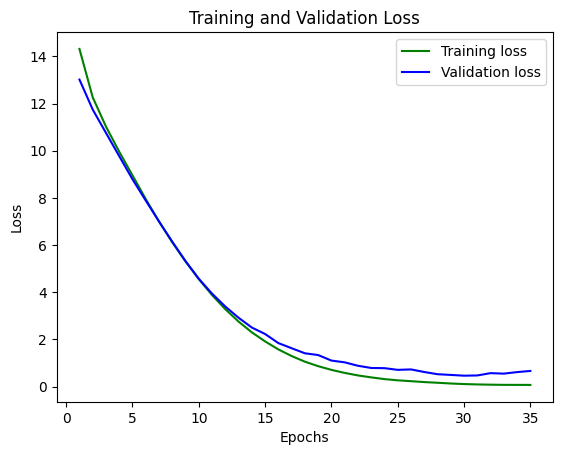

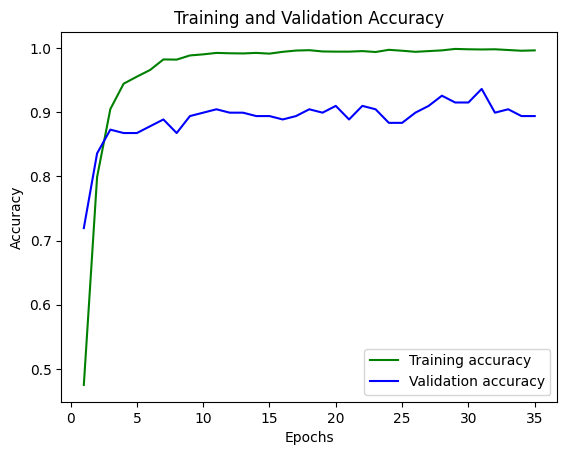

In [60]:
# Plot the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# SAVE MODEL

In [305]:
# Save the model
model.save('6Classes.h5')

# TEST MODEL

In [12]:
# Load the saved model
loaded_model = tf.keras.models.load_model('6ClassesL2.h5')

# Get the class labels from the model
class_labels = loaded_model.predict(np.zeros((1, 256, 256, 3)))

# Define the class labels in the order they were trained
ordered_class_labels = ['Cataract','Conjunctivitis','Ectropion','Normal','Pterygium','Trachoma']

1/1 [==============================] - 3s 3s/step


In [13]:
def preprocess_image(image_path):
    # Preprocess a test image
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.  # Normalize the image
    return img_array

def predict_disease(image_path, ax):
    # Predict disease for a single image
    img_array = preprocess_image(image_path)
    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=-1)

    # Check if the predicted class index is within bounds
    if 0 <= predicted_class[0] < len(ordered_class_labels):
        predicted_label = ordered_class_labels[predicted_class[0]]
        print(f"For image {image_path}, the predicted class is: {predicted_label}")

        # Display the original image
        ax.imshow(image.load_img(image_path, target_size=(256, 256)))
        ax.set_title(f'Predicted Class: {predicted_label}')
        ax.axis('off')

def predict_diseases_in_folder(folder_path):
    # Predict diseases for all images in a folder
    num_images = len(os.listdir(folder_path))
    num_rows = (num_images + 2) // 3  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

    for i, filename in enumerate(os.listdir(folder_path)):
        if filename.endswith(('.jpg', '.jpeg', '.png', 'PNG')):  # Adjust the file extensions as needed
            image_path = os.path.join(folder_path, filename)
            img_array = preprocess_image(image_path)
            prediction = loaded_model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=-1)

            # Check if the predicted class index is within bounds
            if 0 <= predicted_class[0] < len(ordered_class_labels):
                predicted_label = ordered_class_labels[predicted_class[0]]

                # Display the original image
                row = i // 3
                col = i % 3
                predict_disease(image_path, axes[row, col])

    plt.show()

1/1 [==============================] - 0s 154ms/step
For image DATASET/test/pterygium\Image_1.jpg, the predicted class is: Pterygium
1/1 [==============================] - 0s 139ms/step
For image DATASET/test/pterygium\Image_19.jpg, the predicted class is: Pterygium
1/1 [==============================] - 0s 146ms/step
For image DATASET/test/pterygium\Image_26.jpg, the predicted class is: Normal
1/1 [==============================] - 0s 128ms/step
For image DATASET/test/pterygium\Image_6.jpg, the predicted class is: Pterygium
1/1 [==============================] - 0s 138ms/step
For image DATASET/test/pterygium\pterygium (2).PNG, the predicted class is: Pterygium
1/1 [==============================] - 0s 138ms/step
For image DATASET/test/pterygium\pterygium (21).PNG, the predicted class is: Pterygium
1/1 [==============================] - 0s 134ms/step
For image DATASET/test/pterygium\pterygium (27).PNG, the predicted class is: Pterygium
1/1 [==============================] - 0s 130ms/st

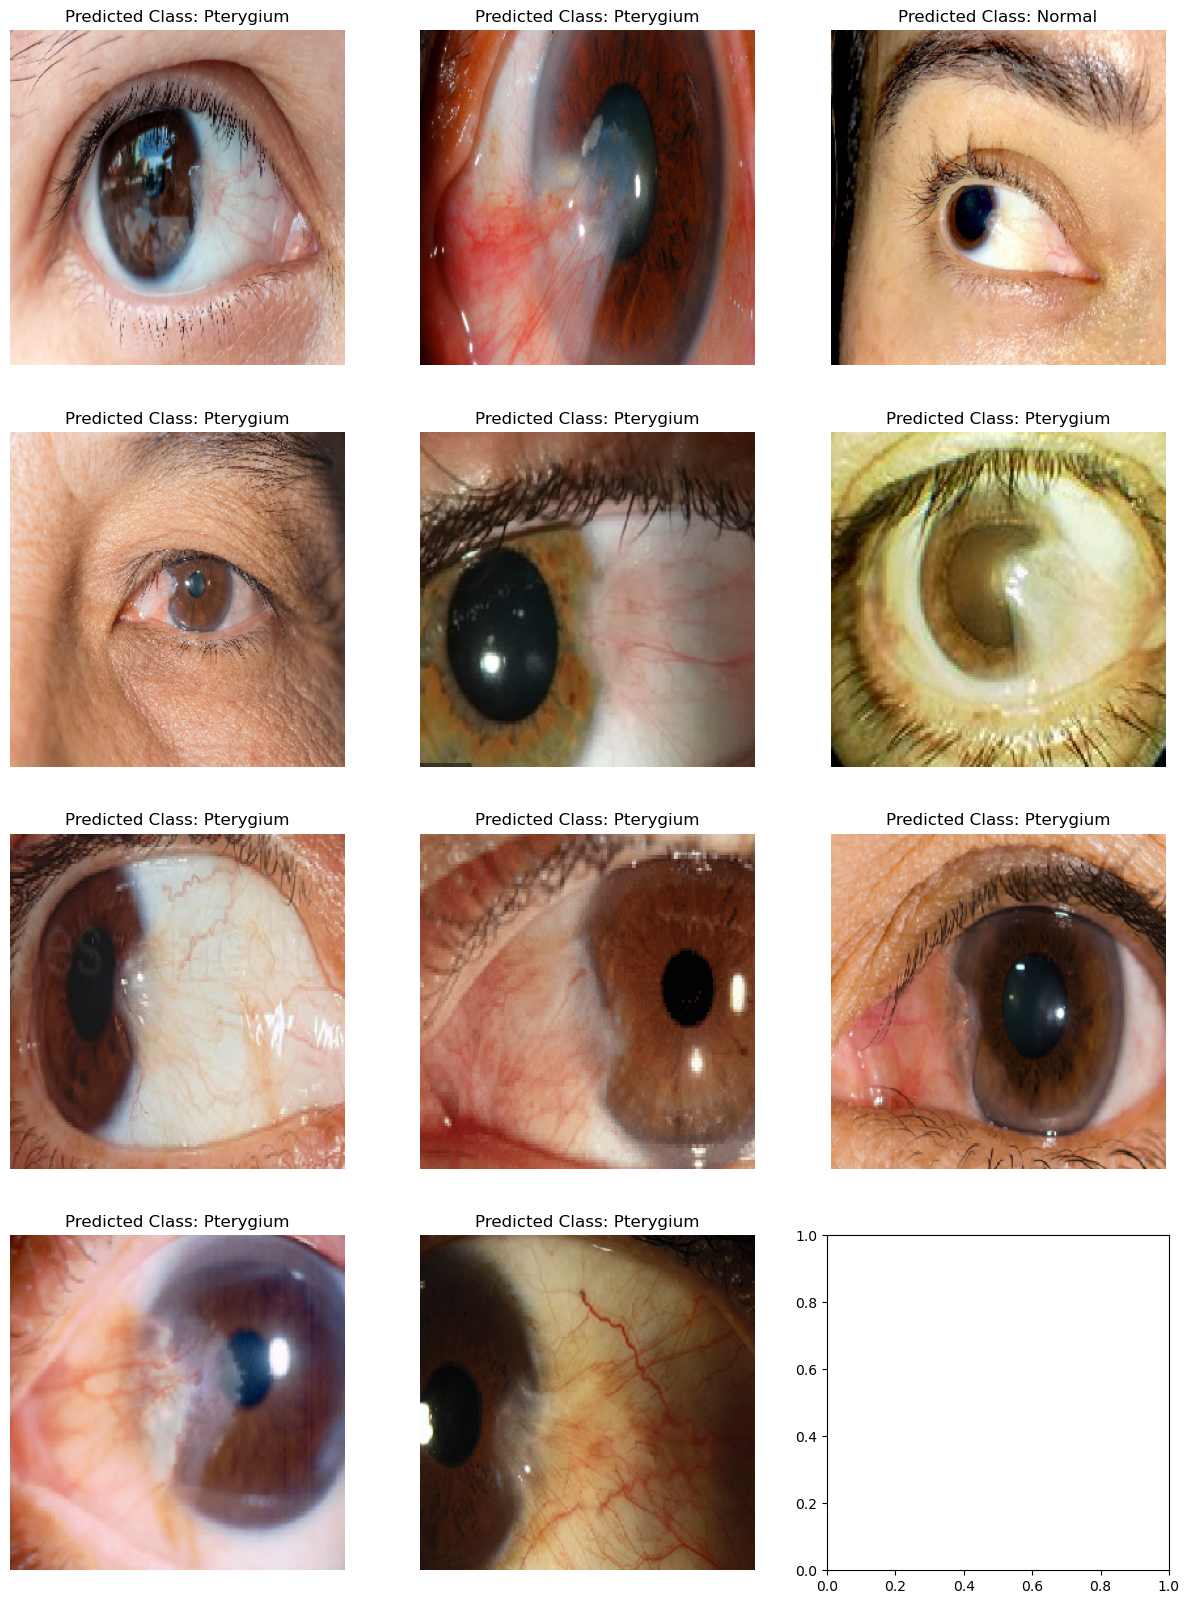

In [15]:
# Specify the folder path containing test images
test_folder_path = 'DATASET/test/pterygium'  # Change this to your test folder path

# Predict diseases for all images in the specified folder
predict_diseases_in_folder(test_folder_path)